In [1]:
from IPython.display import display, Image as iImage
import os
import random
from scipy import ndimage
import numpy as np
from scipy import misc
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.utils import normalize, to_categorical
PATH_TO_notMNIST_SMALL="data/notMNIST_small"
PATH_TO_notMNIST_large="data/notMNIST_large"
PATH_TO_IMAGES=PATH_TO_notMNIST_large
PATH_TO_PICKLED_DATA="data/Lab1"
CLASS_LABELS=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
%matplotlib ipympl
%matplotlib inline

In [2]:
for class_label in CLASS_LABELS:
    for file in os.listdir(f"{PATH_TO_IMAGES}/{class_label}")[:1]:
        path = f"{PATH_TO_IMAGES}/{class_label}/{file}"
        display(iImage(path))

In [3]:
for class_label in CLASS_LABELS:
    dir_size=len(os.listdir(f"{PATH_TO_IMAGES}/{class_label}"))
    print(f"Quantity of class with label {class_label} -> {dir_size}")

Quantity of class with label A -> 52912
Quantity of class with label B -> 52912
Quantity of class with label C -> 52912
Quantity of class with label D -> 52912
Quantity of class with label E -> 52912
Quantity of class with label F -> 52912
Quantity of class with label G -> 52912
Quantity of class with label H -> 52912
Quantity of class with label I -> 52912
Quantity of class with label J -> 52911


In [4]:
def make_array(num_rows, img_size):
    dataset = np.ndarray((num_rows, img_size*img_size), dtype=np.float)
    labels = np.ndarray(num_rows, dtype=np.int32)
    return dataset, labels

def read_image(image_path, image_size, pixel_depth):
    try:
        image=Image.open(image_path)
        image_data = np.array(image).astype(np.float).reshape(1, image_size*image_size)
        if np.isnan(image_data).any():
            return
        return image_data
    except IOError as e:
        print(f"Can't read file {image_path}, exception {e}")
        
def fill_array_with_images(label_to_path_map, size, image_size, pixel_depth):
    num_classes=len(label_to_path_map)
    dataset, dataset_labels=make_array(size, image_size)
    size_per_class = size // num_classes
    row_idx=0
    labels=list(label_to_path_map.keys())
    for class_label in labels:
        paths=label_to_path_map[class_label]
        if labels.index(class_label)==len(labels)-1:
            to_add=size_per_class+size%num_classes
        else:
            to_add=size_per_class
        added=0
        while added<to_add:
            dataset[row_idx, : ]=read_image(paths[random.randint(0, len(paths)-1)], image_size, pixel_depth)
            if np.isnan(dataset[row_idx, : ]).any():
                continue
            else:
                dataset_labels[row_idx]=class_label
                added+=1
                row_idx+=1
    return dataset, dataset_labels

def merge_datasets(label_to_path_map, train_size, valid_size, test_size, image_size, pixel_depth):
    valid_dataset, valid_labels = fill_array_with_images(label_to_path_map, valid_size, image_size, pixel_depth)
    train_dataset, train_labels = fill_array_with_images(label_to_path_map, train_size, image_size, pixel_depth)
    test_dataset, test_labels = fill_array_with_images(label_to_path_map, test_size, image_size, pixel_depth)
    return train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels
            
            
train_size = 500000
valid_size = 15000
test_size = 20000
image_size = 28 
pixel_depth = 255.0
label_to_path_map={
    class_idx:[
        f"{PATH_TO_IMAGES}/{class_label}/{file_name}" for file_name in os.listdir(f"{PATH_TO_IMAGES}/{class_label}")]
    for class_idx, class_label in enumerate(CLASS_LABELS)
}
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels=merge_datasets(label_to_path_map, train_size, valid_size, test_size, image_size, pixel_depth)
train_dataset.shape, test_dataset.shape, valid_dataset.shape

Can't read file data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png, exception cannot identify image file 'data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'
Can't read file data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png, exception cannot identify image file 'data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'
Can't read file data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png, exception cannot identify image file 'data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'
Can't read file data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png, exception cannot identify image file 'data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'
Can't read file data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png, exception cannot identify image file 'data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'
Can't read file data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png, exception cannot identify image file 'data/notMNIST_large/

((500000, 784), (20000, 784), (15000, 784))

In [5]:
def find_overlaps(a_arr, b_arr):
    overlaps=[]
    hash_table={}
    for idx, a_row in enumerate(a_arr):
        hsh = hash(tuple(a_row.tolist()))
        if hsh in hash_table:
            hash_table[hsh].append(idx)
        else:
            hash_table[hsh] = [idx]
    for b_row in b_arr:
        hsh = hash(tuple(b_row.tolist()))
        if hsh in hash_table:
            for idx in hash_table[hsh]:
                if np.array_equal(a_arr[idx], b_row):
                      overlaps.append(idx)
    return overlaps
overlaps=find_overlaps(train_dataset,np.vstack((valid_dataset, test_dataset)))

In [6]:
if overlaps:
    train_idxes=np.array(overlaps)
    mask=np.array([True]*train_dataset.shape[0])
    mask[train_idxes]=False
    train_dataset=train_dataset[mask, :]
    train_labels=train_labels[mask]
    print(f"Removed {train_size-train_dataset.shape[0]} from train dataset, shape - {train_dataset.shape}")
else:
    print("No overlaps found")


Removed 46823 from train dataset, shape - (453177, 784)


In [7]:
def pickle_dataset(dataset, file_path):
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print(f"Unable to save data to {file_path}, reason {e}")
X_train = normalize(train_dataset, axis=1)
y_train = train_labels

X_test = normalize(test_dataset, axis=1)
y_test = test_labels

X_valid = normalize(valid_dataset, axis=1)
y_valid = valid_labels
pickle_dataset(X_train, f"{PATH_TO_PICKLED_DATA}/X_train")
pickle_dataset(y_train, f"{PATH_TO_PICKLED_DATA}/y_train")
pickle_dataset(X_test, f"{PATH_TO_PICKLED_DATA}/X_test")
pickle_dataset(y_test, f"{PATH_TO_PICKLED_DATA}/y_test")
pickle_dataset(X_valid, f"{PATH_TO_PICKLED_DATA}/X_valid")
pickle_dataset(y_valid, f"{PATH_TO_PICKLED_DATA}/y_valid")

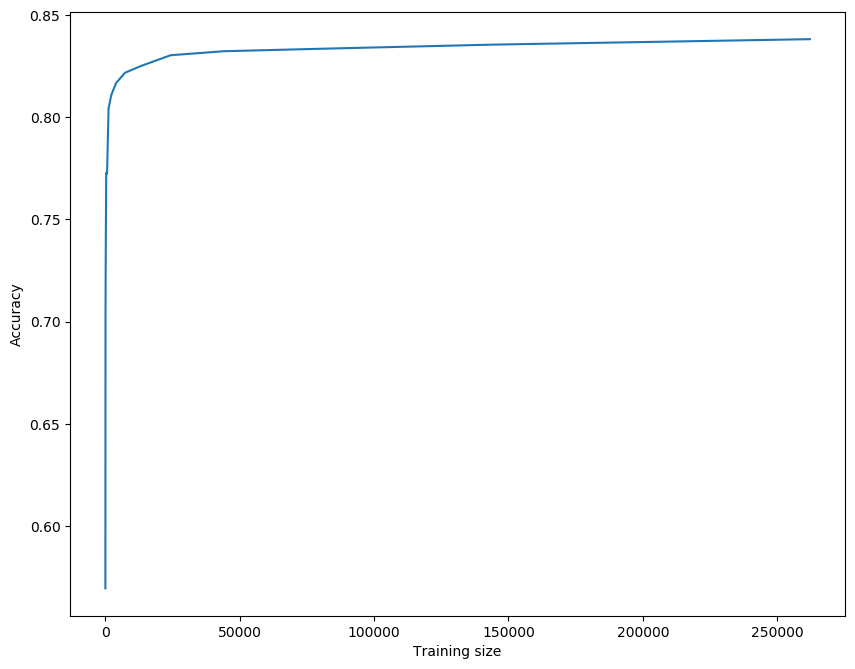

In [8]:
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
X_scoring=[]
y_scoring=[]
for learning_set_size in np.logspace(6, 18, num=15, base=2):
    scores=[]
    learning_set_size=int(learning_set_size)
    splits=StratifiedShuffleSplit(n_splits=3, test_size=10, random_state=0, train_size=learning_set_size)
    for train_index, _ in splits.split(X_train, y_train):
        lg.fit(X_train[train_index], y_train[train_index])
        y_pred = lg.predict(X_test)
        score=metrics.accuracy_score(y_test, y_pred)
        scores.append(score)
    X_scoring.append(learning_set_size)
    y_scoring.append(np.mean(score))
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(X_scoring, y_scoring)
plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.show()